# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) The libraries needed to run this file. Except for numpy, scikit-learn, pandas, matplotlib

Your peers should be able to use the readme section for instructions and be able to run this file. 

Make sure to keep your answers concise. Maximum number of words is 1000, which you can count with the code below. (You can add around 600 words since we start at around 400).

In [1]:
# If this cell does not work try running `pip install nbformat`

import io
import nbformat

nb = nbformat.read("Lab1-2021.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 371


## Group Number :31

## Student 1 
### Name :Yuqian Song
### ID :4630521

## Student 2
### Name : Akash Amalan
### ID : 4682505

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## 1. Visualization task – 1 A4

### 1a. Plot visulations

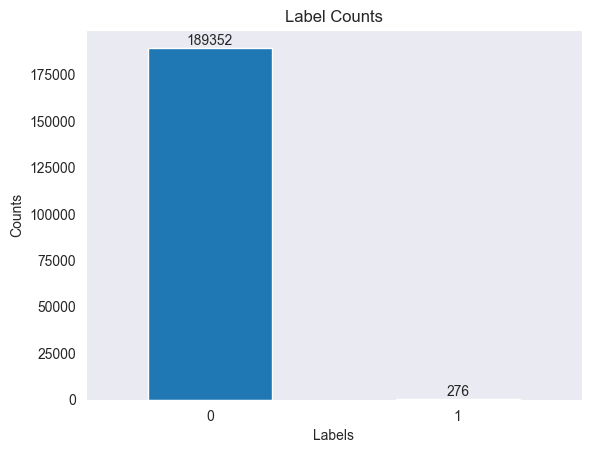

In [3]:

pd_data = pd.read_csv('train_data.csv')
data = pd_data.to_numpy()
features = data[:,:-1]
labels = data[:, -1]


unique, counts = np.unique(labels, return_counts=True)

ax = pd_data["label"].value_counts().plot(kind='bar', title='Label Counts', rot=0, grid=False)
ax.set_xlabel("Labels")
ax.set_ylabel("Counts")

for container in ax.containers:
    ax.bar_label(container)

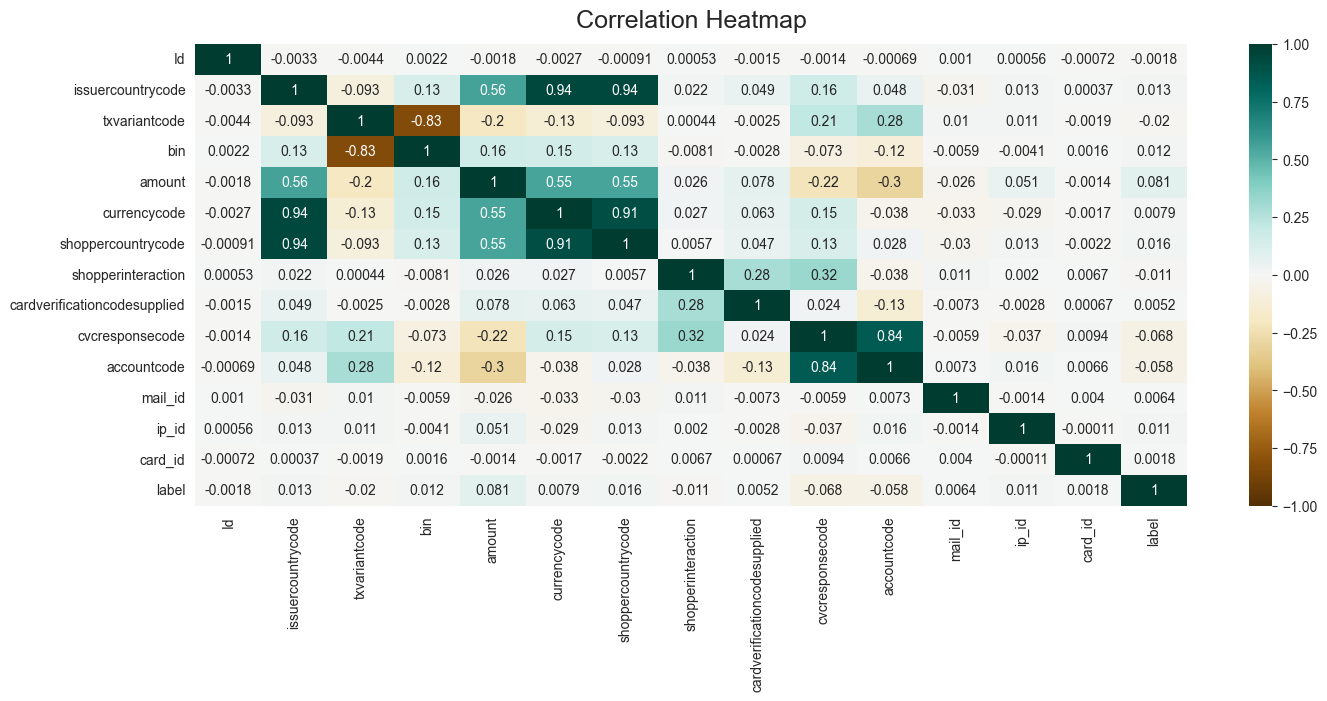

In [4]:

data_converted = pd_data.copy()
data_converted['issuercountrycode']=data_converted['issuercountrycode'].astype('category').cat.codes
data_converted['txvariantcode']=data_converted['txvariantcode'].astype('category').cat.codes
data_converted['currencycode']=data_converted['currencycode'].astype('category').cat.codes
data_converted['shoppercountrycode']=data_converted['shoppercountrycode'].astype('category').cat.codes
data_converted['shopperinteraction']=data_converted['shopperinteraction'].astype('category').cat.codes
data_converted['cardverificationcodesupplied']=data_converted['cardverificationcodesupplied'].astype('category').cat.codes
data_converted['cvcresponsecode']=data_converted['cvcresponsecode'].astype('category').cat.codes
data_converted['accountcode']=data_converted['accountcode'].astype('category').cat.codes
data_converted['mail_id']=data_converted['mail_id'].astype('category').cat.codes
data_converted['ip_id']=data_converted['ip_id'].astype('category').cat.codes
data_converted['card_id']=data_converted['card_id'].astype('category').cat.codes


plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data_converted.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);



[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [15] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [15] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[6]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
     PC                       feature       loading  type
0   PC1                            Id -9.999956e-01  best
1   PC2                       card_id -9.616774e-01  best
2   PC3                       mail_id -7.326491e-01  best
3   PC4                         ip

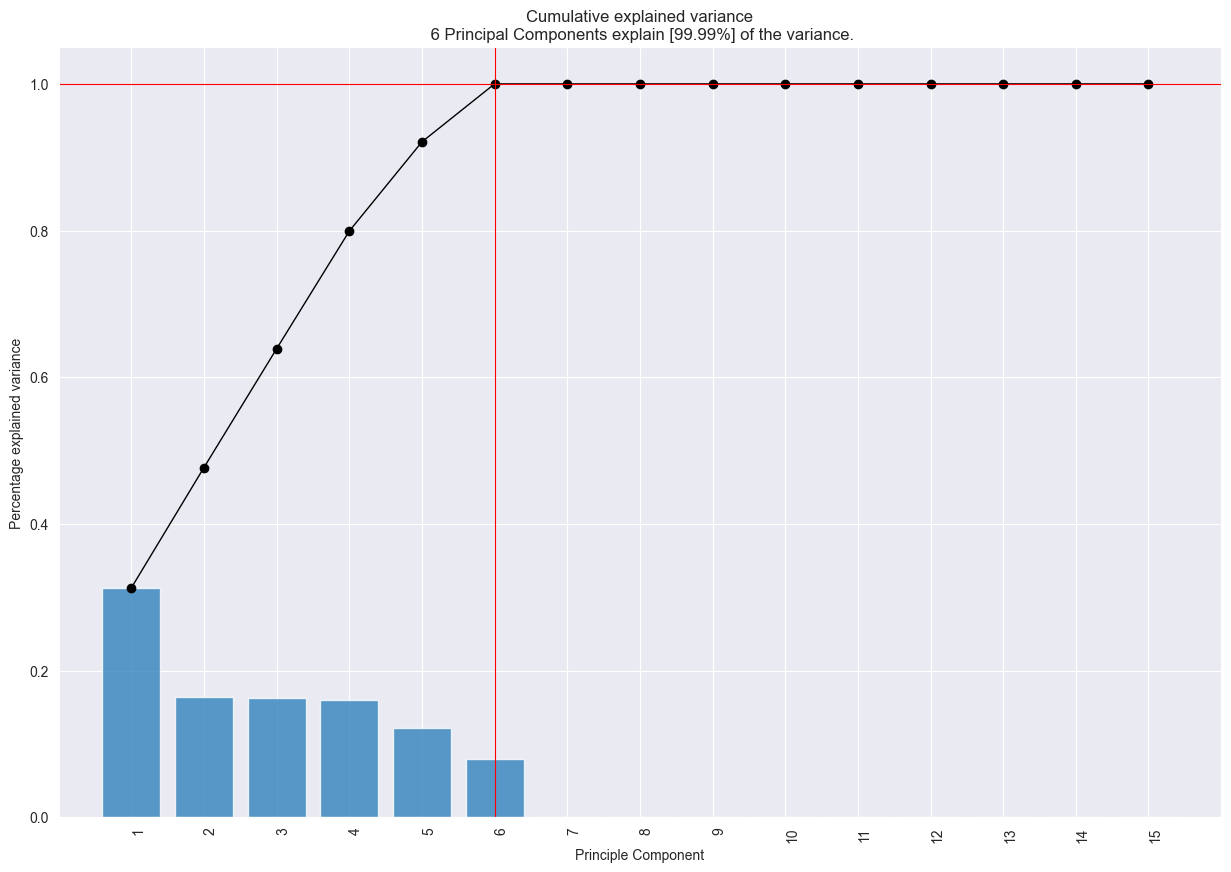

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 6 Principal Components explain [99.99%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 640x480 with 0 Axes>

In [5]:
from pca import pca

data_pca= data_converted.copy(deep=True)
data_pca.drop(columns=['label'])
model = pca()
out = model.fit_transform(data_pca)

print(out['topfeat'])
# Fit transform
model.plot()

### 1b. Describe the visualizations and provide relavant explanations of features and relations.

## 2. Imbalance task – 1 A4 – Individual

In [8]:
### Smote###

import random

def SMOTE(T, N, k):
    if N < 100:
        T = random.sample(T, int((N/100) * len(T)))
        N = 100
    N = int(N / 100)
    numattrs = len(T[0]) if T else 0
    Synthetic = []
    newindex = 0

    for i in range(len(T)):
        nnarray = get_nearest_neighbors(T, i, k)
        newindex = populate(T, N, i, nnarray, numattrs, Synthetic, newindex)

    return Synthetic

def populate(T, N, i, nnarray, numattrs, Synthetic, newindex):
    while N != 0:
        nn = random.randint(0, len(nnarray) - 1)
        attr = [0] * numattrs

        for attr_index in range(numattrs):
            dif = T[nnarray[nn]][attr_index] - T[i][attr_index]
            gap = random.random()
            attr[attr_index] = T[i][attr_index] + gap * dif

        Synthetic.append(attr)
        newindex += 1
        N -= 1

    return newindex

def get_nearest_neighbors(T, i, k):
    distances = []
    for j in range(len(T)):
        if j != i:
            dist = euclidean_distance(T[i], T[j])
            distances.append((j, dist))

    distances.sort(key=lambda x: x[1])
    neighbors = [distances[m][0] for m in range(k)]

    return neighbors

def euclidean_distance(v1, v2):
    return sum((p-q)^2 for p, q in zip(v1, v2))   ** 1/2

SyntaxError: invalid syntax (2849784767.py, line 3)

In [10]:
import random


def rank_swap(data, p):
    """
    Rank swapping for a given dataset.

    Parameters:
    data (list of lists): The dataset.
    p (int): The number of rows to consider when selecting a row to swap.

    Returns:
    data (list of lists): The dataset with rank swapped rows.
    """
    # Get the number of attributes and rows in the dataset.
    num_attrs = len(data[0])
    num_rows = len(data)

    # Rank values of each attribute in ascending order.
    ranks = {}
    for i in range(num_attrs):
        ranks[i] = sorted(set(row[i] for row in data))

    for i in range(num_attrs):
        for j in range(num_rows):

            p_min = max(0, j - p)
            p_max = min(num_rows - 1, j + p)
            r_prime = random.randint(p_min, p_max)

            temp = data[j][i]
            data[j][i] = data[r_prime][i]
            data[r_prime][i] = temp

    return data

[[4, 5, 6], [7, 2, 9], [1, 8, 3], [10, 11, 12]]


### 2a. Print ROC curves

Finished processing data
Applied SMOTE


C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training on SVC
Finished training on RFC
Finished training on LR


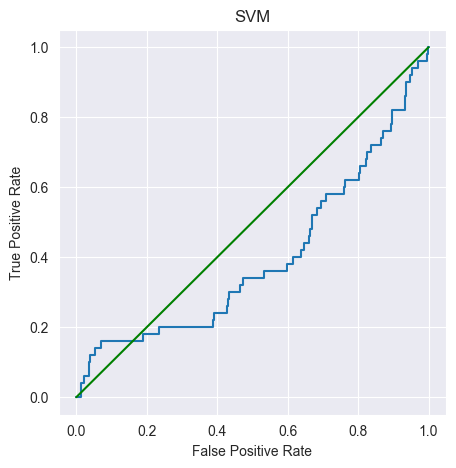

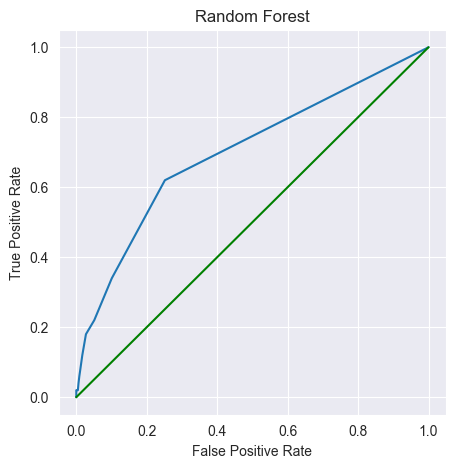

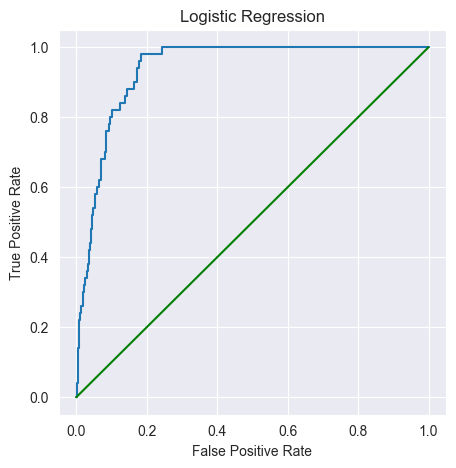

In [20]:
data_transformed =  data_converted.to_numpy()
X = data_transformed[:, :-1]
y = data_transformed[:, -1].astype(int)


pipe = Pipeline([('scaler', StandardScaler())])
Xt = pipe.fit_transform(X)

random_state = 200

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
print("Finished processing data")

data_train = np.column_stack((X_train,y_train))
data= rank_swap(data_train, 2)
X_res, y_res = data[:, :-1], data[: , -1]
# sm = SMOTE(random_state=random_state)
# X_res, y_res = sm.fit_resample(X_train, y_train)
print("Applied SMOTE")


#SVC
svc = svm.LinearSVC(random_state= random_state)
svc.fit(X_res, y_res)
y_proba = svc._predict_proba_lr(X_test)
print("Finished training on SVC")


#Random Forest
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1, class_weight='balanced', random_state= random_state)
rfc.fit(X_res, y_res)
y_probarfc = rfc.predict_proba(X_test)
print("Finished training on RFC")

#LR
lr = LogisticRegression(solver = 'newton-cholesky', penalty='l2', C = 100, n_jobs=-1, random_state= random_state)
lr.fit(X_res, y_res)
y_probalr = lr.predict_proba(X_test)
print("Finished training on LR")


def plot_sklearn_roc_curve(y_real, y_pred, title):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
    plt.title(title)

plot_sklearn_roc_curve(y_test, y_proba[:, 1], "SVM")
plot_sklearn_roc_curve(y_test, y_probarfc[:, 1], "Random Forest")
plot_sklearn_roc_curve(y_test, y_probalr[:, 1], "Logistic Regression")


### 2b. Analyse the performance of the classifiers. Explain which method performs best.

### 2c. Is using SMOTE a good idea? Why (not)?

## 3. Privacy task – 1 A4 – Individual

### 3a. Print ROC curves

### 3b. Analyse the performance of the classifiers. Explain which method performs best.

### 3c. Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

## 4. Classification task – 2 A4

### 4a. Print relevant plots and metrics with clear headings.

### 4b. Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

## 5. Bonus task – 1 A4

### 5a. Provide code and report below